# Hail Skills: Working with Hail Tables and MatrixTables

This notebook shows how to perform sample QC on a Hail MatrixTable as a pre-GWAS step and save it as a Table to an Apollo database (dnax://) on the DNAnexus platform. See documentation for guidance on launch specs for the JupyterLab with Spark Cluster app for different data sizes: https://documentation.dnanexus.com/science/using-hail-to-analyze-genomic-data


Note: For population scale data, samples may be referred to as individuals. In this notebook, the word "sample" will be used.

Pre-conditions for running this notebook successfully:
- There is an existing Hail MatrixTable in DNAX

## 1) Initiate Spark and Hail

Make sure to open up the Spark Interface at https://job-url:8081/jobs/

In [2]:
# Running this cell will output a red-colored message- this is expected.
# The 'Welcome to Hail' message in the output will indicate that Hail is ready to use in the notebook.

from pyspark.sql import SparkSession
import hail as hl

builder = (
    SparkSession
    .builder
    .enableHiveSupport()
)
spark = builder.getOrCreate()
hl.init(sc=spark.sparkContext)



pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 2.4.4
SparkUI available at http://ip-172-31-34-162.ec2.internal:8081
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.78-b17627756568
LOGGING: writing to /opt/notebooks/hail-20230418-1956-0.2.78-b17627756568.log


 # Load in a Table from Project Storage
 
 
 The first thing we'll do in hail is load a pheno file from project storage. 
 
 We'll use `hl.import_table()` for this. We have to specify our key for the file. We will use `iid` (individual ID) as our key.

In [3]:
# Import the pheno CSV file as a Hail Table

pheno_table = hl.import_table("file:///mnt/project/data/ukbb_100k_bmi_casecontrol.csv",
                              delimiter=',',
                              impute=True,
                              key='iid') # specify the column that will be the key (values must match what is in the MT 's' column)


2023-04-18 19:57:56 Hail: INFO: Reading table to impute column types
2023-04-18 19:58:01 Hail: INFO: Finished type imputation
  Loading field 'fid' as type str (imputed)
  Loading field 'iid' as type str (imputed)
  Loading field 'father_iid' as type int32 (imputed)
  Loading field 'mother_iid' as type int32 (imputed)
  Loading field 'sex_code' as type int32 (imputed)
  Loading field 'case_control_status' as type int32 (imputed)


### Quick Hail Table EDA

Three really helpful functions:

- `.describe()` - gives the fields and their data types for our Hail Table
- `.count()` - counts the number of rows in our Hail Table
- `.show()` - shows the first few rows of our dataset.

In [4]:
pheno_table.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'fid': str 
    'iid': str 
    'father_iid': int32 
    'mother_iid': int32 
    'sex_code': int32 
    'case_control_status': int32 
----------------------------------------
Key: ['iid']
----------------------------------------


In [10]:
pheno_table.count()

19884

In [5]:
pheno_table.show()

,,,,,
fid,iid,father_iid,mother_iid,sex_code,case_control_status
str,str,int32,int32,int32,int32
"""sample_1_10""","""sample_1_10""",0,0,1,2
"""sample_1_10003""","""sample_1_10003""",0,0,2,2
"""sample_1_10014""","""sample_1_10014""",0,0,2,1
"""sample_1_10020""","""sample_1_10020""",0,0,1,2
"""sample_1_10021""","""sample_1_10021""",0,0,2,1
"""sample_1_10023""","""sample_1_10023""",0,0,1,1
"""sample_1_10036""","""sample_1_10036""",0,0,2,1
"""sample_1_10037""","""sample_1_10037""",0,0,1,1


Calling `.summarize()` on a Hail Table will give you an overview of missing values and data types for each of your columns in your Hail Table

In [ ]:
pheno_table.summarize()

For our `pheno_table`, we can also show a column by using the `.` accessor with `.show()`. By default, it will show the column along wi†h the row key for the dataset (`iid`)

In [6]:
pheno_table.case_control_status.show()

,
iid,case_control_status
str,int32
"""sample_1_10""",2
"""sample_1_10003""",2
"""sample_1_10014""",1
"""sample_1_10020""",2
"""sample_1_10021""",1
"""sample_1_10023""",1
"""sample_1_10036""",1
"""sample_1_10037""",1


An additional method we can use on numeric columns is `.summarize()`, which will give a numeric summary of the column. Since we don't have a numeric column, we'll do it on the `sex_code` column:

In [5]:
pheno_table.sex_code.summarize()

Non-missing,19884 (100.00%)
Missing,0
Minimum,1
Maximum,2
Mean,1.54
Std Dev,0.50


### Specifying new columns using .annotate()

We can define new columns in our Hail Table using the `.annotate()` method. This is a lot like the `mutate()` function in R/Tidyverse. We can compute new values based on other columns in our dataset.

Here we're subtracting 1 from both the `sex_code` and `case_control_status` columns so that we can use them as a phenotype and a covariate in our downstream analysis.

In [25]:
pheno_table2 = pheno_table.annotate(sc= pheno_table.sex_code -1, ccs=pheno_table.case_control_status -1)
pheno_table2.show()

2023-04-18 21:01:24 Hail: INFO: Coerced sorted dataset


,,,,,,,
fid,iid,father_iid,mother_iid,sex_code,case_control_status,sc,ccs
str,str,int32,int32,int32,int32,int32,int32
"""sample_1_10""","""sample_1_10""",0,0,1,2,0,1
"""sample_1_10003""","""sample_1_10003""",0,0,2,2,1,1
"""sample_1_10014""","""sample_1_10014""",0,0,2,1,1,0
"""sample_1_10020""","""sample_1_10020""",0,0,1,2,0,1
"""sample_1_10021""","""sample_1_10021""",0,0,2,1,1,0
"""sample_1_10023""","""sample_1_10023""",0,0,1,1,0,0
"""sample_1_10036""","""sample_1_10036""",0,0,2,1,1,0
"""sample_1_10037""","""sample_1_10037""",0,0,1,1,0,0


### Filtering our pheno_table using `.filter()`

The `.filter()` method is used a lot in Hail, for subsetting tables. We'll leverage this ability to filter on our QC tables and then subset our MatrixTable with our filtered table.

In [8]:
pheno3 = pheno_table2.filter(pheno_table2.sc == 0)
pheno3.show()

2023-04-18 20:01:22 Hail: INFO: Coerced sorted dataset


,,,,,,,
fid,iid,father_iid,mother_iid,sex_code,case_control_status,sc,ccs
str,str,int32,int32,int32,int32,int32,int32
"""sample_1_10""","""sample_1_10""",0,0,1,2,0,1
"""sample_1_10020""","""sample_1_10020""",0,0,1,2,0,1
"""sample_1_10023""","""sample_1_10023""",0,0,1,1,0,0
"""sample_1_10037""","""sample_1_10037""",0,0,1,1,0,0
"""sample_1_10047""","""sample_1_10047""",0,0,1,1,0,0
"""sample_1_10056""","""sample_1_10056""",0,0,1,2,0,1
"""sample_1_10074""","""sample_1_10074""",0,0,1,2,0,1
"""sample_1_10077""","""sample_1_10077""",0,0,1,1,0,0


## Getting Categorical Breakdowns

We can count categories using `pheno3.aggregate()` and `hl.agg.counter()`. Here we're getting the categorical breakdown of the recoded Case Constrol Status variable `pheno3.ccs`.

Keep in mind that these operations can be expensive to calculate in terms of CPU time. That doesn't mean that you shouldn't do it, but even getting descriptive statistics on a Hail Table can take some time.

In our case, our `pheno3` Hail Table is pretty small, so we can 

In [11]:
pheno3.aggregate(hl.agg.counter(pheno3.ccs))

frozendict({0: 4637, 1: 4503})

## Plotting the Hail Table

We can plot the Hail Table using `hl.plot.histogram()` on our columns of interest. There are a number of different kinds of plots in `hl.plot`.

The first thing we need to do is to load some modules from `Bokeh`, which will make our graphs more interactive.

In [35]:
from bokeh.io import output_notebook, show
output_notebook()


Loading BokehJS ...

Now we can use `hl.plot.histogram()` on columns in our Hail Table. We'll see that the plotting works similarly for MatrixTables

In [36]:
p = hl.plot.histogram(pheno_table2.ccs, title='Distribution of Cases/Controls', legend='ccs')
show(p)

In [37]:
p = hl.plot.histogram(pheno_table2.sc, range=(0,1), bins=100, title='Distribution of Gender', legend='sc')
show(p)

## Working with MatrixTables

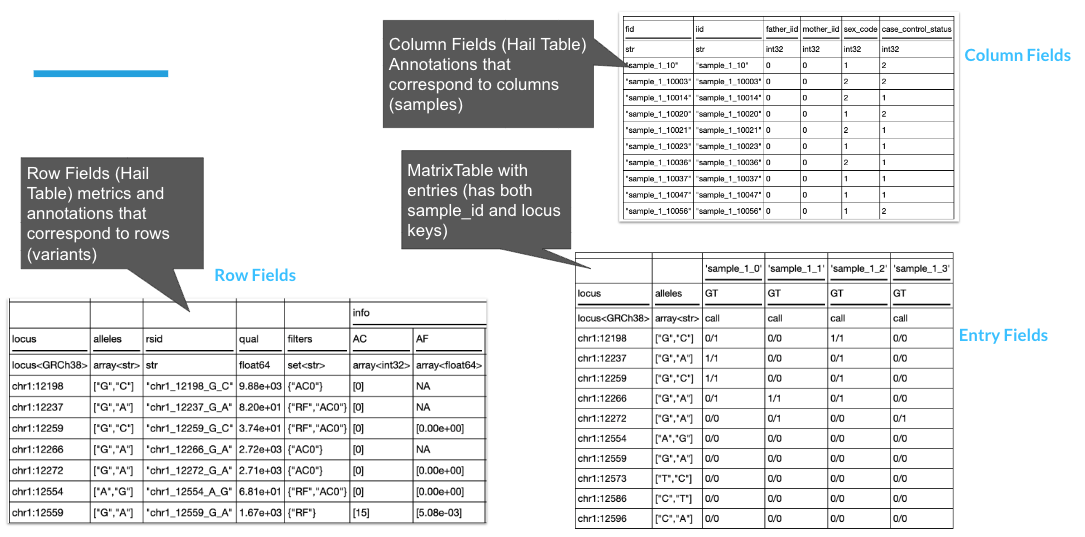

MatrixTables are an extension of HailTables. They work like a 2-D matrix with two tables that are attached to them:

1) Columns (Sample Based Operations), accessed using `.cols()` 

2) Rows (Variant based operations. accessed using `.rows()`

If you remember this, it makes MatrixTable operations more understandable.

We'll load in a MatrixTable that I've already created. This was created from the pVCF files in the `Geno_Data/` directory using the `hl.import_vcf()` function, and then written to a dnax database using `mt.write()`. (see `supplementary_notebooks/01_import_pVCF.ipynb`)

In [9]:
# read MT
mt_url="dnax://database-GQYV2Bj04bPg9X3KfFyj2jyY/geno.mt"
mt = hl.read_matrix_table(mt_url)

We can see from using `.describe()` that there are Column and Row fields.

In [10]:
# View structure of MT before QC

mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DB: bool, 
        DP: int32, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MQ: float64, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        SOR: float64, 
        VQSLOD: float64, 
        VQSR_culprit: str, 
        VQSR_NEGATIVE_TRAIN_SITE: bool, 
        VQSR_POSITIVE_TRAIN_SITE: bool, 
        GQ_HIST_ALT: array<str>, 
        DP_HIST_ALT: array<str>, 
        AB_HIST_ALT: array<str>, 
        GQ_HIST_ALL: str, 
        DP_HIST_ALL: str, 
        AB_HIST_AL

We can see the actual genotype calls for each locus and each sample using `mt.GT.show()`:

In [11]:
mt.GT.show()

,,,,,
,,'sample_1_0','sample_1_1','sample_1_2','sample_1_3'
locus,alleles,GT,GT,GT,GT
locus<GRCh38>,array<str>,call,call,call,call
chr1:12198,"[""G"",""C""]",0/1,0/0,1/1,0/0
chr1:12237,"[""G"",""A""]",1/1,0/0,0/1,0/0
chr1:12259,"[""G"",""C""]",1/1,0/0,0/1,0/0
chr1:12266,"[""G"",""A""]",0/1,1/1,0/1,0/0
chr1:12272,"[""G"",""A""]",0/0,0/1,0/0,0/1
chr1:12554,"[""A"",""G""]",0/0,0/0,0/0,0/0
chr1:12559,"[""G"",""A""]",0/0,0/0,0/0,0/0


If we do a `.show()` operation on `mt.rows()` we will retrieve the keys used in the row operations. Here they are a combination of locus position and the allele at that position.

In [12]:
mt.row_key.show()

,
locus,alleles
locus<GRCh38>,array<str>
chr1:12198,"[""G"",""C""]"
chr1:12237,"[""G"",""A""]"
chr1:12259,"[""G"",""C""]"
chr1:12266,"[""G"",""A""]"
chr1:12272,"[""G"",""A""]"
chr1:12554,"[""A"",""G""]"
chr1:12559,"[""G"",""A""]"
chr1:12573,"[""T"",""C""]"


We can access a row field (here AF = Allele Frequency) by first going into the `.info` slot and then accessing the `AF` field within it. 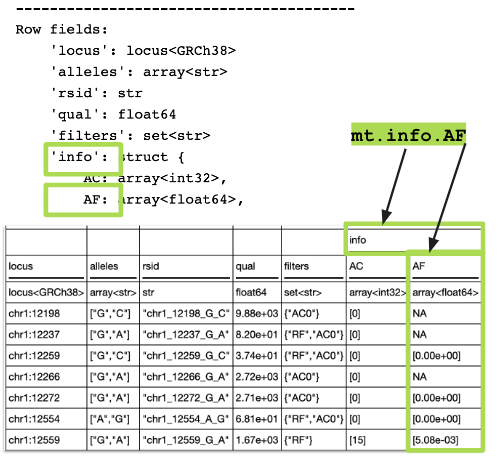

Keep this in mind for when you are using `.filter_rows()`, since it's how you will accesss the fields.

In [ ]:
mt.info.AF.show()

If we use `mt.aggregate_entries()` and `hl.agg.counter()` on mt.GT.n_alt_alleles(), we will get the distribution of zygosities for our entire MatrixTable. 

In [ ]:
mt.aggregate_entries(hl.agg.counter(mt.GT.n_alt_alleles()))

## 3) Run Hail's sample QC method

If we use `hl.sample_qc()` on our MatrixTable, it will create a new MatrixTable that has the QC information attached. You'll notice that we have an additional column field called `mt.sample_qc`.

Note that we're not going to create the sample QC table here - we will load it from the DNAX store when we do our GWAS. This is because it takes some time to calculate. For more about sample QC, refer to the OpenBio Sample QC notebook here: https://github.com/dnanexus/OpenBio/blob/master/hail_tutorial/sample_qc.ipynb

*Additional documentation: https://hail.is/docs/0.2/methods/genetics.html#hail.methods.sample_qc*

In [17]:
# DON'T RUN in class
# Run sample-level QC

qc_mt = hl.sample_qc(mt)

In [18]:
# View structure of MT after QC
# Don't Run this cell

qc_mt.describe()

----------------------------------------

Global fields:

    None

----------------------------------------

Column fields:

    's': str

    'sample_qc': struct {

        dp_stats: struct {

            mean: float64, 

            stdev: float64, 

            min: float64, 

            max: float64

        }, 

        gq_stats: struct {

            mean: float64, 

            stdev: float64, 

            min: float64, 

            max: float64

        }, 

        call_rate: float64, 

        n_called: int64, 

        n_not_called: int64, 

        n_filtered: int64, 

        n_hom_ref: int64, 

        n_het: int64, 

        n_hom_var: int64, 

        n_non_ref: int64, 

        n_singleton: int64, 

        n_snp: int64, 

        n_insertion: int64, 

        n_deletion: int64, 

        n_transition: int64, 

        n_transversion: int64, 

        n_star: int64, 

        r_ti_tv: float64, 

        r_het_hom_var: float64, 

        r_insertion_deletion: float6

We can see that a new column field called 'sample_qc' has been added the MT. Note that the `sample_qc` field is not calculated yet. If we do a `.show()`, then we will calculate the QC metrics.

This step took a long time to calculate, over 20 minutes on a six node instance (`mem2_ssd1_v2_x8`), so we won't calculate it.

In [20]:
%%timeit
qc_mt.cols().show()

2023-04-11 16:20:15 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.

    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


+------------------+-------------------------+--------------------------+
| s                | sample_qc.dp_stats.mean | sample_qc.dp_stats.stdev |
+------------------+-------------------------+--------------------------+
| str              |                 float64 |                  float64 |
+------------------+-------------------------+--------------------------+
| "sample_1_0"     |                     NaN |                      NaN |
| "sample_1_1"     |                     NaN |                      NaN |
| "sample_1_10"    |                     NaN |                      NaN |
| "sample_1_100"   |                     NaN |                      NaN |
| "sample_1_1000"  |                     NaN |                      NaN |
| "sample_1_10000" |                     NaN |                      NaN |
| "sample_1_10001" |                     NaN |                      NaN |
| "sample_1_10002" |                     NaN |                      NaN |
| "sample_1_10003" |                     NaN |                      NaN |
| "sample_1_10004" |                     NaN |                      NaN |
+------------------+-------------------------+--------------------------+

+------------------------+------------------------+-------------------------+
| sample_qc.dp_stats.min | sample_qc.dp_stats.max | sample_qc.gq_stats.mean |
+------------------------+------------------------+-------------------------+
|                float64 |                float64 |                 float64 |
+------------------------+------------------------+-------------------------+
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
|                     NA |                     NA |                     NaN |
+------------------------+------------------------+-------------------------+

+--------------------------+------------------------+------------------------+
| sample_qc.gq_stats.stdev | sample_qc.gq_stats.min | sample_qc.gq_stats.max |
+--------------------------+------------------------+------------------------+
|                  float64 |                float64 |                float64 |
+--------------------------+------------------------+------------------------+
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
|                      NaN |                     NA |                     NA |
+--------------------------+------------------------+------------------------+

+---------------------+--------------------+------------------------+
| sample_qc.call_rate | sample_qc.n_called | sample_qc.n_not_called |
+---------------------+--------------------+------------------------+
|             float64 |              int64 |                  int64 |
+--------------------

We see that there is a column in `qc_mt.sample_qc` called `call_rate`.  We can access it using:

`qc_mt.sample_qc.call_rate` or `qc_mt["sample_qc"]["call_rate"]` if we want to do something with it.

## 4) Create sample QC Table and save in Apollo Database

Now that we have calculated our sample qc metrics, we can save them as a separate table. We are mostly doing this for convenience and speed.

In our case, this has already been done and calculated, so we're just showing the process of storing a MatrixTable into `dnax`.

Note we could also do `mt.write("dnax://{db_name}/geno.mt")` and store the MatrixTable into dnax as well. Using `dnax` is helpful because Hail can read the MatrixTable directly from `dnax`.

In [21]:
# Create Hail Table from MT
# note we use .cols() to access the column (sample) fields
qc_tb = qc_mt.cols()

In [9]:
# Define database and table name

# Note: It is recommended to only use lowercase letters for the database name.
# If uppercase lettering is used, the database name will be lowercased when creating the database.
db_name = "db_mt_test2"
tb_name = "sample_qc.ht"

In [10]:
# DON'T RUN in class
# Create database in DNAX

stmt = f"CREATE DATABASE IF NOT EXISTS {db_name} LOCATION 'dnax://'"
print(stmt)
spark.sql(stmt).show()

CREATE DATABASE IF NOT EXISTS db_mt_test2 LOCATION 'dnax://'

++

||

++

++




In [ ]:
# DON'T RUN in class
# Store Table in DNAXc
import dxpy

# find database ID of newly created database using a dxpy method
db_uri = dxpy.find_one_data_object(name=f"{db_name}", classname="database")['id']
url = f"dnax://{db_uri}/{tb_name}"

# Before this step, the Hail Table is just an object in memory. To persist it and be able to access 
# it later, the notebook needs to write it into a persistent filesystem (in this case DNAX).
# See https://hail.is/docs/0.2/hail.Table.html#hail.Table.write for additional documentation.
qc_tb.write(url) # Note: output should describe size of Table (i.e. number of rows, partitions)